# GIS Analysis of Mechanical Turk Trueskill scores #
**Author:** Andrew Larkin <br>
**Date created:** May 10, 2020 <br>
**Summary:** Perform GIS analyses of MT trueskill scores.  Analyses include: <br>
 - Calculate Moran's I for each label and urban category

### import libraries and define global static constants ###

In [1]:
import arcpy as ap
import pandas as ps
import numpy as np
import globalConstants as gConst
ap.CheckOutExtension("Spatial")
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
ATT_FIELDS = [
        "avg_mu_gre","avg_mu_rel","avg_mu_bea","avg_mu_saf",
        "bMean_gree","bMean_rela","bMean_beau","bMean_safe",
        "bStd_green","bStd_relax","bStd_beaut","bStd_safe"
    ]
FIELD_LABELS = [
    "nature","relax","beauty","safety",
    "bias nature","bias relax","bias beauty","bias safety",
    "sd nature","sd relax","sd beauty","sd safety"
]
SHORT_LABEL_LIST = FIELD_LABELS[0:4]    
WORKSPACE = gConst.ENV_WORKSPACE
SHAPEFILE_NAME = "mturkGIS2.shp"

### calculate Morans I for one urban category, all labels ###
**Inputs:** <br>
- **catType** (string array) - urban category to screen by
- **statLabels** (string array) - statistics categories 
- **urbType** (string array) - urban category type, with one element for each row in the final output table
- **stats** (float array of arrays) - one array for each column of statistics
- **outcomeLabels** (string array) - labels to calculate statistics for
- **shapefileName** (string) - local name of the shapefile 

**Outputs:** <br>
- **statLabels** (string array) - statistics categories
- **urbType** (string array) - updated version of the urbType input
- **stats** (float array of arrays) - updated version of the stats input
- **outcomeLabels** (string) - updated version of the shapefileName input

In [3]:
def calcMoransIOneDataset(catType,statLabels,urbType,stats,outcomeLabels,shapefileName):
    if(catType!='all'):
        whereClause = '"urban_cat" = ' + str(catType)
        tempFile = ap.SelectLayerByAttribute_management(shapefileName,"NEW_SELECTION",whereClause)
    else:
        tempFile = shapefileName
    for fieldIndex in range(len(ATT_FIELDS)):
        attField = ATT_FIELDS[fieldIndex]
        labelName = FIELD_LABELS[fieldIndex]
        outcomeLabels.append(labelName)
        moransI = ap.SpatialAutocorrelation_stats(
            tempFile,attField,"NO_REPORT","INVERSE_DISTANCE",
            "EUCLIDEAN_DISTANCE","NONE","1000"
        )
        moranList = moransI.getMessages().split('\n')
        statLabels = []
        for valIndex in range(7,12):
            tempVal = moranList[valIndex]
            val = tempVal.replace(" ", "")
            startIndex = val.rfind(':')
            statLabels.append(val[0:startIndex])
            stats[valIndex-7].append(val[startIndex+1:])
        urbType.append(catType)
    return([statLabels,urbType,stats,outcomeLabels])

### helper function to get names of fields in shapefile.  Useful because ArcGIS abbreviates fields when converting from csv to shapefile ###

In [4]:
def getFieldNames():
    try:
        ap.env.workspace = WORKSPACE
        fields = ap.ListFields(SHAPEFILE_NAME)
        for field in fields:
            print(field.name)
    except Exception as e:
        print(str(e))

In [5]:
getFieldNames()

FID
Shape
Field1
img
avg_mu_gre
avg_sigma_
abs_mu_gre
image_id_x
n_greenspa
urban_cat
lat
lon
angle
image_id_y
bMean_gree
bStd_green
bMean_x
bStd_x
avg_mu_rel
avg_sigma1
abs_mu_rel
image_id_1
n_relax
bMean_rela
bStd_relax
bMean_y
bStd_y
avg_mu_saf
avg_sigm_1
abs_mu_saf
image_id_2
n_safe
bMean_safe
bStd_safe
bMean
bStd
avg_mu_bea
avg_sigm_2
abs_mu_bea
image_id
n_beauty
bMean_beau
bStd_beaut


### calculate Morans I for all urban categories, all labels ###

In [6]:
def calcMoransI():
    try:
        ap.env.workspace = WORKSPACE
        statLabels,stats,urbType,outcomeLabels = [],[[],[],[],[],[]],[],[]
        statLabels,urbType,stats,outcomeLabels = calcMoransIOneDataset(
            "all",statLabels,urbType,stats,outcomeLabels,SHAPEFILE_NAME
        )
        statLabels,urbType,stats,outcomeLabels = calcMoransIOneDataset(
            0,statLabels,urbType,stats,outcomeLabels,SHAPEFILE_NAME
        )
        statLabels,urbType,stats,outcomeLabels = calcMoransIOneDataset(
            1,statLabels,urbType,stats,outcomeLabels,SHAPEFILE_NAME
        )
        statLabels,urbType,stats,outcomeLabels = calcMoransIOneDataset(
            2,statLabels,urbType,stats,outcomeLabels,SHAPEFILE_NAME
        )
    
        dF = ps.DataFrame()
        dF['urbType'] = urbType
        dF['label'] = outcomeLabels
        for statIndex in range(len(statLabels)):
            dF[statLabels[statIndex]] = stats[statIndex]
        return(dF)
    except Exception as e:
        print("ERROR")
        print(str(e))
        print(ap.GetMessages())

### convert Morans I dataframe into a heatmap ###
**Inputs:**
- **moranDF** (pandas dataframe) - Morans I statistics and metadata, in pandas DF format
- **inLabels** (str array) - list of outcome labels.  Used to extract specific values associated with each label out of the dataframe and into the correct numpy array cell

**Outputs**
- **heatMapArray** (float numpy array) - Morans I values transformed into np array format (rows are labels, cols are urban categories)

In [7]:
def createHeatMapArray(moranDF,inLabels):
    urbTypes = ['all',0,1,2]
    heatMapArray = np.zeros((len(inLabels),len(urbTypes)))
    for labelIndex in range(len(inLabels)):
        labelSubset = moranDF[moranDF['label']==inLabels[labelIndex]]
        for urbIndex in range(len(urbTypes)):
            urbRecord = labelSubset[labelSubset['urbType']==urbTypes[urbIndex]]
            heatMapArray[labelIndex,urbIndex] = float(urbRecord["Moran'sIndex"])
    heatMapArray = np.round(heatMapArray,2)
    return heatMapArray

### create heatmap of Morans I statistics ###
**Inputs:**
- **dF** (pandas dataframe) - Morans I statistis and metadata, in pandas DF format
- **figSize** (2 element tuple) - x and y dimensions of the output figure size
- **saveFile** (str) - full filepath where heatmap should be written to disk.  Default value ("") doesn't save


In [8]:
def createHeatMap(dF,attrLabels,figSize,saveFile=""):
    urban_labels = ['all','Seattle','urban','rural']

    heatArray = np.transpose(createHeatMapArray(dF,attrLabels))
    fig, ax = plt.subplots(figsize=figSize)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right',size='5%',pad=0.05)

    im = ax.imshow(heatArray,cmap="Greens")
    fig.colorbar(im,cax=cax,orientation='vertical',label="Moran's I")

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(attrLabels)))
    ax.set_yticks(np.arange(len(urban_labels)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(attrLabels)
    ax.set_yticklabels(urban_labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(urban_labels)):
        for j in range(len(attrLabels)):
            curCol = "black" if heatArray[i,j] < 0.5 else "w"
            text = ax.text(j, i, heatArray[i, j],
                           ha="center", va="center", color=curCol)
     
    #ax.set_title("Moran's I by urban category and label")
    fig.tight_layout()
    if(len(saveFile)>0):
        plt.savefig(saveFile)
    plt.show()

### main function ###

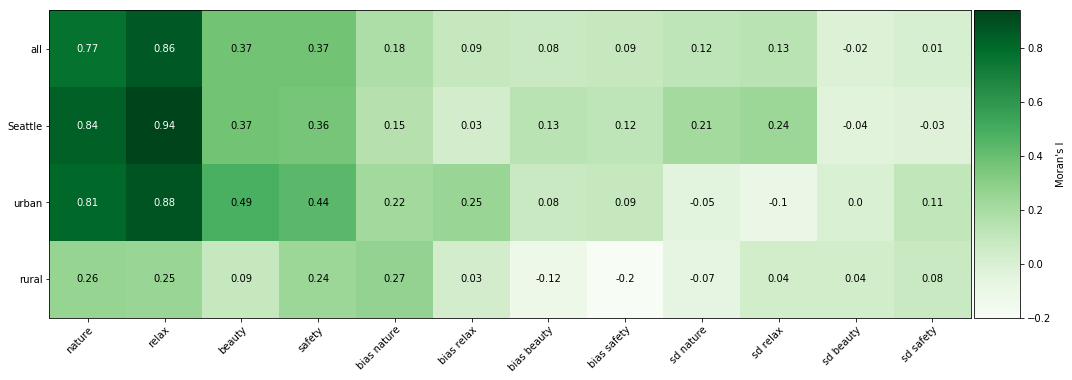

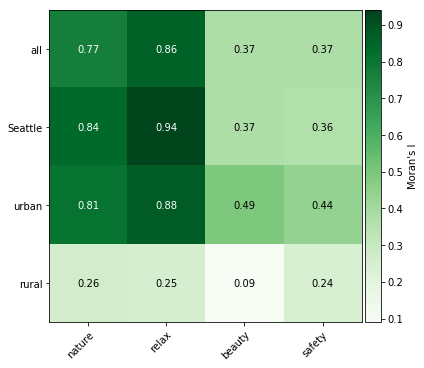

In [9]:
dF = calcMoransI()
createHeatMap(dF,FIELD_LABELS,(15,10),gConst.MORANSI_HEATMAP_IMG)
createHeatMap(dF,SHORT_LABEL_LIST,(6,6),gConst.MORANSI_HEATMAP_IMG_SHORT)